#  Checking GPU Availability

In [1]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


# Data Preprocessing & Augmentation

In [2]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"

# Image size and batch size for training
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training (helps with generalization)
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True)

# Only rescaling for validation & test (no augmentation needed)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_data = train_datagen.flow_from_directory(
    os.path.join(dataset_path, "train"), 
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, 
    class_mode="binary"
)

# Load validation data
val_data = val_datagen.flow_from_directory(
    os.path.join(dataset_path, "val"), 
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, 
    class_mode="binary"
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# Building the CNN Model (Fine-tuned ResNet50)


In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers except the last 10 (fine-tuning)
for layer in base_model.layers[:-10]:  
    layer.trainable = False  # Keep lower-level features frozen

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout to reduce overfitting
output_layer = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Define final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', metrics=['accuracy'])

# Training the Model with Early Stopping



In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Stop training early if no improvement for 10 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce learning rate if validation loss stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=15, callbacks=[early_stop, lr_scheduler])

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.9364 - loss: 0.1664 - val_accuracy: 0.5000 - val_loss: 1.7797 - learning_rate: 2.0000e-05
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.9514 - loss: 0.1335 - val_accuracy: 0.5625 - val_loss: 1.6918 - learning_rate: 2.0000e-05
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.9487 - loss: 0.1436 - val_accuracy: 0.5000 - val_loss: 2.1805 - learning_rate: 2.0000e-05
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.9465 - loss: 0.1476 - val_accuracy: 0.7500 - val_loss: 0.7318 - learning_rate: 2.0000e-05
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.9498 - loss: 0.1229 - val_accuracy: 0.6250 - val_loss: 1.3030 - learning_rate: 2.0000e-05
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9504 - loss: 0.1226
Epoch 6: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
163/163 ━━━━━━━━━━━━━━━━━━━━ 412s 3s/step - accuracy: 

# Evaluating Model 

In [7]:
# Load test data
test_dir = os.path.join(dataset_path, "test")
test_data = val_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary"
)

# Evaluate model on test set
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8166 - loss: 0.4484
Test Accuracy: 80.77%


# visualizing training progress

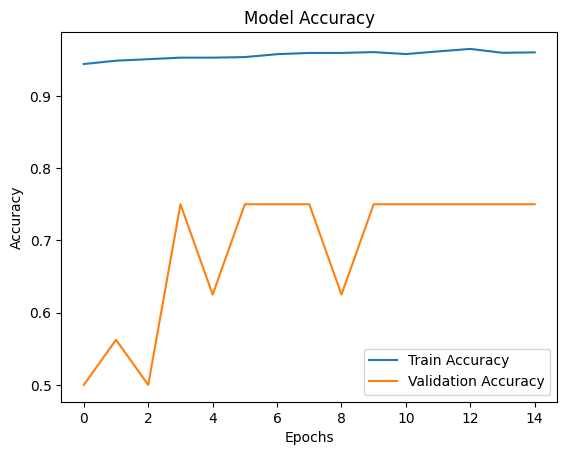

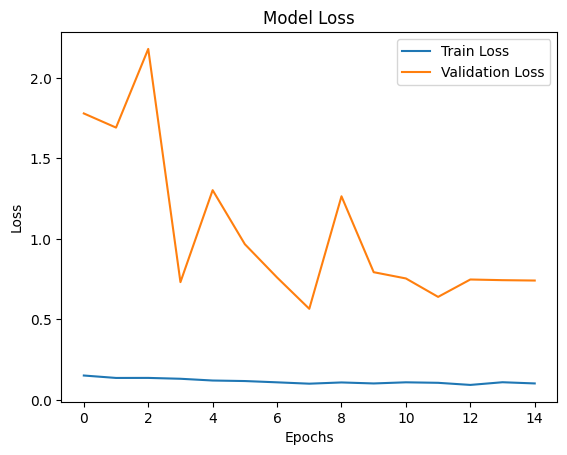

In [8]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [9]:
# saving the model
model.save("/kaggle/working/fine_tuned_resnet.h5")

# Making Predictions on New Images and displaying images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


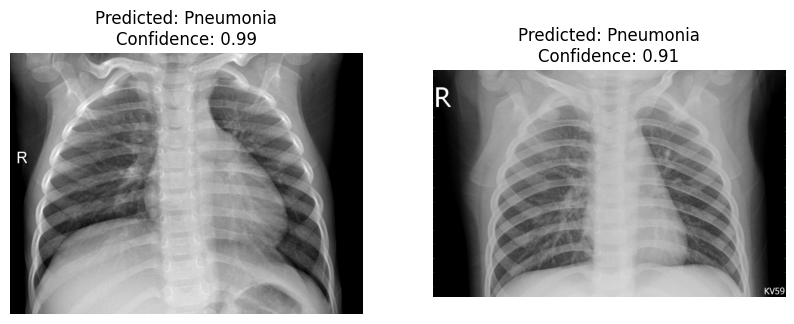

In [15]:
import random
import glob

# Get all test images
test_image_paths = glob.glob("/kaggle/input/chest-xray-pneumonia/chest_xray/test/*/*.jpeg")

# Select 2 random images
random_images = random.sample(test_image_paths, 2)

# Perform predictions
plt.figure(figsize=(10, 5))
for i, image_path in enumerate(random_images):
    img = preprocess_image(image_path)  # Preprocess image
    prediction = model.predict(img)[0][0]  # Get prediction score

    # Display result
    label = "Pneumonia" if prediction > 0.5 else "Normal"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    plt.subplot(1, 2, i+1)
    plt.imshow(cv2.imread(image_path)[..., ::-1])  # Convert BGR to RGB
    plt.axis('off')
    plt.title(f"Predicted: {label}\nConfidence: {confidence:.2f}")

plt.show()